Before taking another steps, I reviewed all the previous ones so far and found some **major bummers**!

I just copied the last notebook, and throughout it I'll signal what went wrong so far!

# Imports

In [1]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

# Importing the Dataset

In [2]:
raw_df = pd.read_csv('../raw_data/data_for_first_model.csv')
df = raw_df.copy()
df

,garage,price,rooms,sqm
0,1,330000,1,40
1,5,1190000,4,411
2,4,1590000,4,158
3,6,550000,3,278
4,1,450000,3,87
...,...,...,...,...
5729,2,560000,3,92
5730,1,440000,3,90
5731,2,500000,3,80
5732,2,740000,3,80


# Quick glimpse at the Dataset information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5734 entries, 0 to 5733
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   garage  5734 non-null   int64
 1   price   5734 non-null   int64
 2   rooms   5734 non-null   int64
 3   sqm     5734 non-null   int64
dtypes: int64(4)
memory usage: 179.3 KB


In [4]:
df.describe()

,garage,price,rooms,sqm
count,5734.000000,5.734000e+03,5734.000000,5734.000000
mean,2.102895,1.007129e+06,2.837286,156.616324
std,1.432552,1.094481e+06,1.247022,146.156526
min,0.000000,4.500000e+02,0.000000,14.000000
25%,1.000000,3.900000e+05,2.000000,73.000000
50%,2.000000,6.730000e+05,3.000000,110.000000
75%,3.000000,1.200000e+06,4.000000,180.000000
max,10.000000,1.500000e+07,10.000000,1460.000000


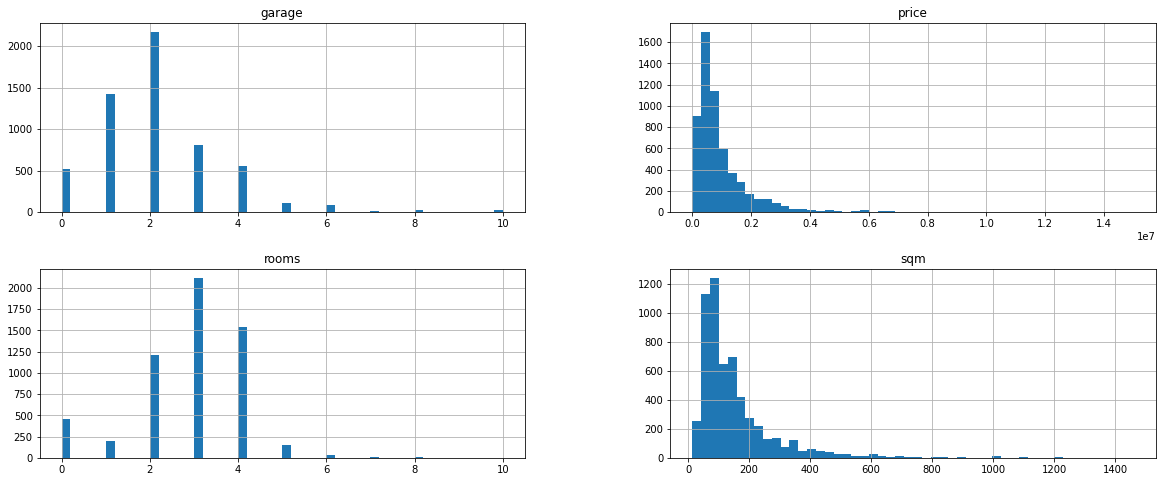

In [5]:
#Checking the distributions
df.hist(bins=50, figsize=(20,8));

In [6]:
df.corr()

,garage,price,rooms,sqm
garage,1.000000,0.564851,0.507149,0.454173
price,0.564851,1.000000,0.289625,0.626187
rooms,0.507149,0.289625,1.000000,0.240331
sqm,0.454173,0.626187,0.240331,1.000000


# FIRST CORRECTION! PAY ATTENTION!

At first, we first **SCALED** the model and then we **SPLIT** the model.

**WROOOOOOONG**

By doing this, we might be **leaking data**! When scaling the full set, we are using information that is not suppose to be seen by any means before the test step! Even for scaling!

We might end up with a **lower score model**, but at least it will be **more reliable**!

# Defining the Train and Test set

## Defining X and Y

In [7]:
#As debated before, we won't use the 'Rooms' feature for now
y = df['price']
X = df[['garage', 'sqm']]

## Splitting the Sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Scaling the Data

Non-Gaussian and without outliers: the best scaler in this scenario is the **MIN MAX SCALER**.

In [9]:
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_train

array([[0.2       , 0.06777317],
       [0.        , 0.03803596],
       [0.1       , 0.02143845],
       ...,
       [0.3       , 0.11065007],
       [0.        , 0.34993084],
       [0.2       , 0.08852006]])

# Structuring the Model

## Scaling the Test Set

In [10]:
#We must use the same 'scaler' used to scale the Trainning Set, so we'll have the same line of thought
X_test = scaler.transform(X_test)
X_test

array([[0.1       , 0.07399723],
       [0.2       , 0.03181189],
       [0.2       , 0.06224066],
       ...,
       [0.4       , 0.14591978],
       [0.2       , 0.06777317],
       [0.        , 0.83125864]])

## Baseline Model/Dummy Model

In [11]:
baseline_model = DummyRegressor()
baseline_model.fit(X_train, y_train)
score = baseline_model.score(X_test, y_test)
score

-0.00022771617872474614

That's a **terrible** (but expected) result.

## Linear Regression

In [12]:
model = LinearRegression()
cv_results = cross_validate(model, X_train, y_train, cv=5, scoring='r2')
cv_results['test_score'].mean()

0.4795539295673065

**0.50**? Better than the Baseline Model, but it's just like throwing a coin!

**NEW INFORMATION: It dropped from 0.50 to 0.47, as predicted before! However, the model works in a more reliable way.**

## Checking the Learning Curves

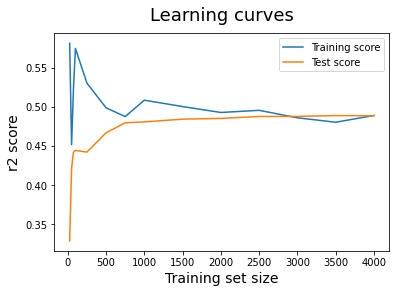

In [13]:
#Define our Train Sizes inside the function, or store it outside in a variable just like you did here;
train_sizes = [25,50,75,100,250,500,750,1000,1500,2000,2500,3000,3500,4000]

        #The function output consists in 5 arrays: train_sizes_abs, train_scores, test_scores, fit_times and score_times;
        #The function performs an Automatic Cross Validation (again, the 'cv' is the number of folds);
        #The 'estimator' must be an object that can perform both 'fit' and 'test' methods;
train_sizes, train_scores, test_scores = learning_curve(estimator=LinearRegression(), X=X, y=y, train_sizes=train_sizes, cv=5, scoring='r2')

        #Compute the mean of the Cross-Validated Train Scores and Test Scores;
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

        #And now plot the whole thing;
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

At least the model doesn't seem to be under/over-fitting.

## Checking the Residuals

In [14]:
#Instantiating and trainning a model;
model = LinearRegression().fit(X_train, y_train)
#Predicting house prices with the model;
predictions = model.predict(X_test)
#Checking the difference between the predictions and the real prices
residuals = y_test - predictions

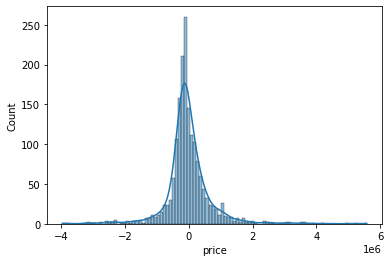

In [15]:
sns.histplot(residuals, bins=100, kde=True);

**OLD NOTES**: We can clearly see a Gaussian distribution centered (apparently) on zero. That's a good start, however, we do have some considerable residual episodes from a model with a R² Score of 0.5. That's not the best result ever. Maybe, considering location as a feature might help us improve the model's score/predictions. **(This was written upon a wrong data approach)**

**CORRECT NOTE**: The residuals are a **MESS**!!! So distorted towards negative values, not centered and with a weird noise! 

## Decision Tree

Let's use a **Gridsearch** to check the best params for our tree.

In [16]:
tree = DecisionTreeRegressor()

grid = {'max_depth': [4, 5, 6], 
        'min_samples_split': [2, 3, 4],
        'min_samples_leaf': [10, 20, 30]}

search = GridSearchCV(tree, grid, 
                           scoring = 'r2',
                           cv = 5,
                           n_jobs=-1 # paralellize computation
                          )

search.fit(X_train, y_train)
print(search.best_score_, search.best_params_) # >>> 0.4946606248693768 {'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 2}

#After the correction, the new score increased to 0.5059674350327927, and the new params are:
#{'max_depth': 6, 'min_samples_leaf': 30, 'min_samples_split': 2}

0.4873190992039853 {'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 2}


In [17]:
tree = DecisionTreeRegressor(max_depth=6, min_samples_split=2, min_samples_leaf=30)

cv_results = cross_validate(tree, X, y, scoring = "r2", cv=5)
cv_results['test_score'].mean() # >>> 0.5047109684525231

0.5047109684525231

Let's check the **Learning Curves** as well, to make sure our model is not under/over-fitting.

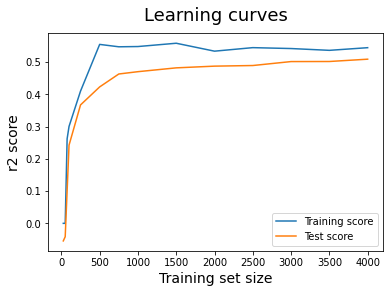

In [18]:
#Define our Train Sizes inside the function, or store it outside in a variable just like you did here;
train_sizes = [25,50,75,100,250,500,750,1000,1500,2000,2500,3000,3500,4000]

        #The function output consists in 5 arrays: train_sizes_abs, train_scores, test_scores, fit_times and score_times;
        #The function performs an Automatic Cross Validation (again, the 'cv' is the number of folds);
        #The 'estimator' must be an object that can perform both 'fit' and 'test' methods;
train_sizes, train_scores, test_scores = learning_curve(DecisionTreeRegressor(max_depth=6, 
                                                                              min_samples_split=2, 
                                                                              min_samples_leaf=30), X=X, y=y, train_sizes=train_sizes, cv=5, scoring='r2')

        #Compute the mean of the Cross-Validated Train Scores and Test Scores;
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

        #And now plot the whole thing;
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

Seems ok! Let's now visualize the structure of our tree!

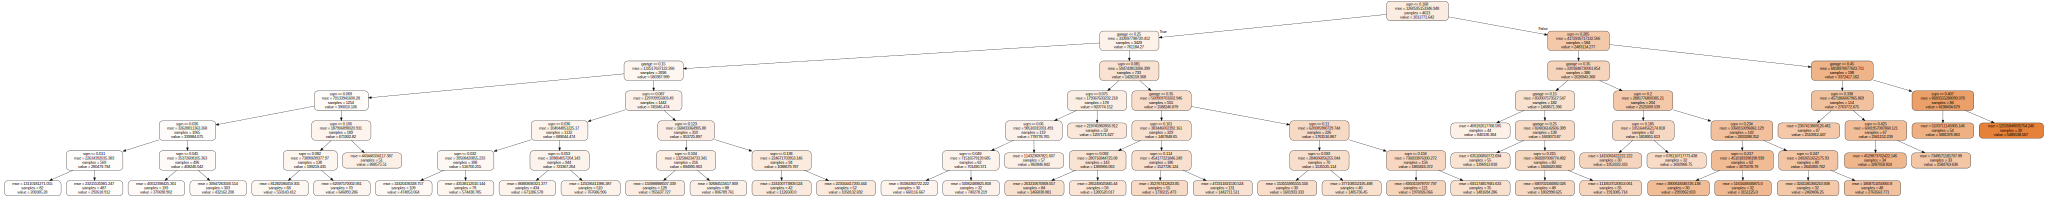

In [19]:
tree.fit(X_train, y_train)

export_graphviz(tree, out_file="housing.dot", 
                feature_names=df[['garage', 'sqm']].columns,
                class_names=['0','1','2'], 
                rounded=True, filled=True)

with open("housing.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

## Random Forest

Since the score still low, let's try modeling with a bunch of Trees.

In [20]:
forest = RandomForestRegressor(n_estimators=100, max_depth=3, min_samples_split=2, min_samples_leaf=5)

cv_results = cross_validate(forest, X_train, y_train, scoring = "r2", cv=5)
cv_results['test_score'].mean() # >>> 0.492875124689673

0.4901927550284932

It even decreased a little bit.

Maybe this is a sign that we are dealing with a small number of occurrences, or maybe our features are not that correlated with our target.

In a future step, let's try to consider the region in which the houses are located to compute how the price might change.

# Final Words

Always remember to split your sets before scale them! Otherwise, you'll be using test set information to base your scaling decisions, which means: **DATA LEAKAGE**!